<a href="https://colab.research.google.com/github/younglaecho/learn_machine_learning/blob/main/chap03_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 다중회귀
여러 개의 특성을 사용한 회귀를 다중 회귀라고 합니다.<br>
1개의 특성을 사용했을 때 선형 회귀 모델이 학습하는 것은 직선이지만, 2개의 특성을 사용하면 평면을 학습합니다.<br>
농어의 길이, 농어의 높이, 농어의 두께를 사용하면, 특성이 3개가 됩니다.<br>
특성이 3개가 되면 우리가 직관적으로 상상할 수 없습니다.<br>
특성이 많아질수록 선형 회귀는 더 복잡한 모델을 표현할 수 있습니다.<br>
특성의 값을 조합하여, 예를 들면 농어길이 x 농어높이, 새로운 특성을 뽑아내는 것을 **특성 공학**이라고 합니다.

In [2]:
import pandas as pd
df = pd.read_csv('https://bit.ly/perch_csv_data')
perch_full = df.to_numpy()

import numpy as np

perch_weight = np.array([5.9, 32.0, 40.0, 51.5, 70.0, 100.0, 78.0, 80.0, 85.0, 85.0, 110.0,
       115.0, 125.0, 130.0, 120.0, 120.0, 130.0, 135.0, 110.0, 130.0,
       150.0, 145.0, 150.0, 170.0, 225.0, 145.0, 188.0, 180.0, 197.0,
       218.0, 300.0, 260.0, 265.0, 250.0, 250.0, 300.0, 320.0, 514.0,
       556.0, 840.0, 685.0, 700.0, 700.0, 690.0, 900.0, 650.0, 820.0,
       850.0, 900.0, 1015.0, 820.0, 1100.0, 1000.0, 1100.0, 1000.0,
       1000.0])

In [3]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(perch_full, perch_weight, random_state=42)

### 사이킷런의 변환기
특성을 만들거나 전처리하기 위한 클래스

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()
poly.fit([[1, 2]])
print(poly.transform([[2,3]]))

[[1. 2. 3. 4. 6. 9.]]


PolynomialFeatures는 특성을 늘려주는 변환기로, 특성 끼리 곱한값, 각특성을 제곱한 값이 들어간다.<br>
추가적으로 절편에 대한 계수로 1이 들어가는데 이 부분은 include_bias로 빼주는게 좋다. <br>
sklearn의 선형회귀에서는 절편을 자동으로 추가하기때문이다.
$$무게 = a × 길이 + b × 높이 + c × 두께 + d × 1 $$


In [13]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(include_bias=False)
poly.fit([[1, 2]])
print(poly.transform([[2,3]]))

[[2. 3. 4. 6. 9.]]


In [16]:
poly = PolynomialFeatures(include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)
print(train_poly.shape)
poly.get_feature_names()

(42, 9)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']

poly.get_feature_names를 통해 특성공학으로 얻어진 특성들이 무엇인지 확인해볼 수 있다.
아래에선 테스트세트 또한 특성을 늘려주었습니다.

In [18]:
test_poly = poly.transform(test_input)

다중회귀 모델을 훈련하는 것은 선형 회귀 모델을 훈련하는 것과 같습니다.

In [21]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_poly, train_target)
print(lr.score(train_poly, train_target))
print(lr.score(test_poly, test_target))

0.9903183436982124
0.9714559911594132


특성을 5제곱까지 추가하면 어떻게 될까요? <br>
특성을 추가하려면 PolynomialFeatures에 degree라는 매개변수를 조정하면됩니다.

In [22]:
poly = PolynomialFeatures(degree=5, include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)
print(train_poly.shape)

(42, 55)


특성이 무려 55개나 되는것을 확인할 수 있습니다.

In [23]:
lr.fit(train_poly, train_target)

print(lr.score(train_poly, train_target))
print(lr.score(test_poly, test_target))

0.9999999999991096
-144.40579242335605


엄청나게 과대적합된 결과를 확인할 수 있습니다. <br>
샘플의 개수보다 특성이 더 많다면 심각하게 과대적합이 됩니다.<br>
**규제**를 통해 이를해결해보겠습니다.

## 규제

일반적으로 선형 회귀 모델에 규제를 적용할 때 계수 값의 스케일이 서로 많이 다르면 공정하게 제어되지 않을 가능성이 큽니다. <br>
따라서 정규화가 필요합니다. 이를 위해 StandardScaler라는 변환기 클래스를 사용하겠습니다.

In [25]:
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
ss.fit(train_poly)
train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

선형 회귀에 규제를 추가한 모델에는 릿지와 라쏘가 있습니다.<br>
릿지 : 계수를 제곱한 값을 기준으로 규제를 적용<br>
라쏘 : 계수의 절댓값을 기준으로 규제를 적용

## 릿지 회귀

In [31]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(train_scaled, train_target)
print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

0.9896101671037343
0.9790693977615397


특성의 개수는 여전히 많지만 규제를 통해 과대적합되지 않을 결과를 보여주고 있습니다.<br

릿지와 라쏘 모델을 사용할 때 규제의 양을 임의로 조절할 수도 있습니다.<br>
alpha라는 매개변수를 통해 규제의 강도를 조절해보겠습니다.<br>
적절한 alpha값을 찾는 방법은 alpha 값에 대한 표준점수를 그래프로 그려보는 것입니다.

In [33]:
import matplotlib.pyplot as plt
train_score = []
test_score = []

alpha_list = [0.001, 0.01, 0.1, 10, 100]
for alpha in alpha_list:
  ridge = Ridge(alpha = alpha)
  ridge.fit(train_scaled, train_target)
  train_score.append(ridge.score(train_scaled, train_target))
  test_score.append(ridge.score(test_scaled, test_target))

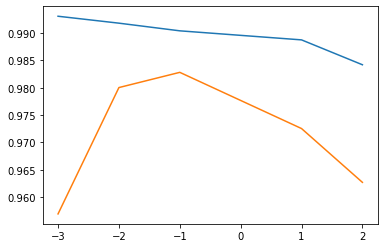

In [34]:
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)

규제의 강도를 0.1로 하는 것이 가장 적합하다는 것을 확인할 수 있습니다.

In [35]:
ridge = Ridge(alpha=0.1)
ridge.fit(train_scaled, train_target)
print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

0.9903815817570366
0.9827976465386927


## 라쏘회귀


In [37]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(train_scaled, train_target)
print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.989789897208096
0.9800593698421883


In [39]:
import matplotlib.pyplot as plt
train_score = []
test_score = []

alpha_list = [0.001, 0.01, 0.1, 10, 100]
for alpha in alpha_list:
  lasso = Lasso(alpha = alpha, max_iter=10000)
  lasso.fit(train_scaled, train_target)
  train_score.append(lasso.score(train_scaled, train_target))
  test_score.append(lasso.score(test_scaled, test_target))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e+04, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.297e+04, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


지정한 반복횟수가 부족할 때 뜨는 경고 있니다. max_iter를 통해 반복횟수를 늘려야만 해결되지만, 큰 문제가 되지는 않아 그냥 두겠습니다.

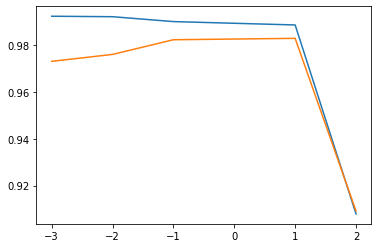

In [41]:
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)

alpha가 10일 때, 가장 적합한 것으로 확인할 수 있습니다.

In [42]:
lasso = Lasso(alpha=10)
lasso.fit(train_scaled, train_target)
print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.9888067471131867
0.9824470598706695


계수가 0이 된 특성을 모두 찾아보겠습니다.

In [43]:
print(np.sum(lasso.coef_ == 0))

40


계수가 0인 특성이 40개나 되어서, 특성이 15개로 줄어버린 것을 확인할 수 있습니다. <br>
